In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from combined_thresh import combined_thresh
from perspective_transform import perspective_transform
from Line import Line
from line_fit import line_fit, tune_fit, final_viz, calc_curve, calc_vehicle_offset
from moviepy.editor import VideoFileClip

In [4]:
pip install moviepy

  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110726 sha256=453ca634c3679956794a337b3f798fc442099ab8f8268825aca9fc1b87a1f9e6
  Stored in directory: c:\users\shweta\appdata\local\pip\cache\wheels\e4\a4\db\0368d3a04033da662e13926594b3a8cf1aa4ffeefe570cfac1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Uninstalling decorator-5.0.6:
      Successfully uninstalled decorator-5.0.6
Note: you may need to restart the kernel to use updated packages.


Moviepy - Building video out.mp4.
Moviepy - Writing video out.mp4



Moviepy - Done !
Moviepy - video ready out.mp4


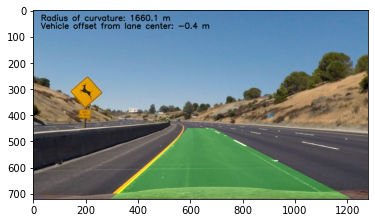

In [2]:
# Global variables (just to make the moviepy video annotation work)
with open('calibrate_camera.p', 'rb') as f:
	save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']
window_size = 5  # how many frames for line smoothing
left_line = Line(n=window_size)
right_line = Line(n=window_size)
detected = False  # did the fast line fit detect the lines?
left_curve, right_curve = 0., 0.  # radius of curvature for left and right lanes
left_lane_inds, right_lane_inds = None, None  # for calculating curvature


# MoviePy video annotation will call this function
def annotate_image(img_in):
	"""
	Annotate the input image with lane line markings
	Returns annotated image
	"""
	global mtx, dist, left_line, right_line, detected
	global left_curve, right_curve, left_lane_inds, right_lane_inds

	# Undistort, threshold, perspective transform
	undist = cv2.undistort(img_in, mtx, dist, None, mtx)
	img, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(undist)
	binary_warped, binary_unwarped, m, m_inv = perspective_transform(img)

	# Perform polynomial fit
	if not detected:
		# Slow line fit
		ret = line_fit(binary_warped)
		left_fit = ret['left_fit']
		right_fit = ret['right_fit']
		nonzerox = ret['nonzerox']
		nonzeroy = ret['nonzeroy']
		left_lane_inds = ret['left_lane_inds']
		right_lane_inds = ret['right_lane_inds']

		# Get moving average of line fit coefficients
		left_fit = left_line.add_fit(left_fit)
		right_fit = right_line.add_fit(right_fit)

		# Calculate curvature
		left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

		detected = True  # slow line fit always detects the line

	else:  # implies detected == True
		# Fast line fit
		left_fit = left_line.get_fit()
		right_fit = right_line.get_fit()
		ret = tune_fit(binary_warped, left_fit, right_fit)
		left_fit = ret['left_fit']
		right_fit = ret['right_fit']
		nonzerox = ret['nonzerox']
		nonzeroy = ret['nonzeroy']
		left_lane_inds = ret['left_lane_inds']
		right_lane_inds = ret['right_lane_inds']

		# Only make updates if we detected lines in current frame
		if ret is not None:
			left_fit = ret['left_fit']
			right_fit = ret['right_fit']
			nonzerox = ret['nonzerox']
			nonzeroy = ret['nonzeroy']
			left_lane_inds = ret['left_lane_inds']
			right_lane_inds = ret['right_lane_inds']

			left_fit = left_line.add_fit(left_fit)
			right_fit = right_line.add_fit(right_fit)
			left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
		else:
			detected = False

	vehicle_offset = calc_vehicle_offset(undist, left_fit, right_fit)

	# Perform final visualization on top of original undistorted image
	result = final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset)

	return result


def annotate_video(input_file, output_file):
	""" Given input_file video, save annotated video to output_file """
	video = VideoFileClip(input_file)
	annotated_video = video.fl_image(annotate_image)
	annotated_video.write_videofile(output_file, audio=False)


if __name__ == '__main__':
	# Annotate the video
	annotate_video('project_video.mp4', 'out.mp4')

	# Show example annotated image on screen for sanity check
	img_file = 'test_images/test2.jpg'
	img = mpimg.imread(img_file)
	result = annotate_image(img)
	result = annotate_image(img)
	result = annotate_image(img)
	plt.imshow(result)
	plt.show()
